# Tutorial 13: Root Finding

## PHYS 2600, Spring 2019

In [2]:
# Import cell
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Setup: the torsion-spring pendulum

Everything in this tutorial will concern a single physics system: a rigid pendulum plus a [torsion spring](https://en.wikipedia.org/wiki/Torsion_spring), with spring constant $\kappa$.  A torsion spring works just like a regular spring, except that it exerts a restoring force based on angle instead of distance.  
We'll assume the spring is unextended (exerts no force) at an angle $\theta = \theta_0$.

<img src="https://physicscourses.colorado.edu/phys2600/phys2600_fa18/img/torsion-spring-pendulum.png" width=400px />

This is pretty simple-looking, but the forces are just complicated enough that we can't solve for the motion analytically.  (In fact, that was already true for just the pendulum, unless we take $\theta$ to be small!)

Instead of looking at the complete motion of this pendulum, let's ask a simpler question: __where are the points of equilibrium__?  That is, at what value (or values) of $\theta$ will the pendulum remain at rest?  

From intro mechanics, we remember that equilibrium points occur where the _potential energy_ of the system has vanishing derivative; with just one coordinate $\theta$ here, we can write simply $U(\theta)$.  The net force on our pendulum at any $\theta$ will be

$$
F(\theta) = -\frac{dU}{d\theta},
$$

so it will stay at rest whenever the derivative vanishes.  Now we write down the potential energy vs. $\theta$:

\\[
U(\theta) = \frac{1}{2} \kappa (\theta - \theta_0)^2 - mgL \cos \theta \\
U'(\theta) = \kappa (\theta - \theta_0) + mgL \sin \theta
\\]

and solving $U'(\theta) = 0$ gives us the equilibrium point(s).  This is _still_ not solvable on pen and paper (it's a transcendental equation), but we have computers!

We could implement our solution below for a general set of parameters, but let's keep it simple and fix a bunch of them as constants: 

* $g = 9.8\ m/s^2$
* $m = 2\ kg$
* $L = 1\ m$
* $\theta_0 = \pi/4$

We'll let the torsion spring constant $\kappa$ be an adjustable parameter, but let's take the default value to be __10 J__.  (We assume that we're working in radians and not degrees, or else some annoying angular conversions show up.)

Before we get to coding, it's a good idea to think carefully about what we expect.  The equation we're trying to solve has the form 

$$
c(x-\pi/4) = -\sin(x)
$$

so in other words, we want the intersection of a line with $-\sin(x)$.  __Run the cell below to plot these two curves from $U'(\theta)$__.  From the plot, it should be evident that for our choice of parameters (or any $\kappa > 0$, in fact) there will be only one solution in this range.

Text(0, 0.5, '$dU/d\\theta$')

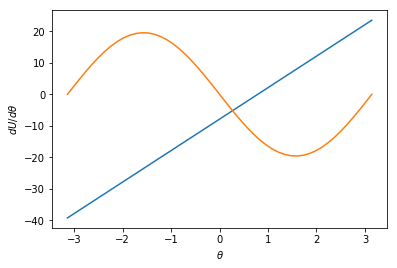

In [3]:
kappa = 10  # J
m = 2  # kg
L = 1  # m
theta_0 = np.pi / 4
g = 9.8  # m/s^2

th = np.linspace(-np.pi, np.pi)

plt.plot(th, kappa * (th - theta_0))
plt.plot(th, -m*g*L*np.sin(th))
plt.xlabel('$\\theta$')
plt.ylabel('$dU/d\\theta$')

## T13.1 - Solving with Brute Force

Let's begin with the simplest approach, _brute force_.  You might think this is a foolish way to attack the problem - and it is, compared to other algorithms available! - but since computers are so fast, this might work better than you expect.

First, we should implement our $U'(\theta)$ as a function `Up(theta)`; then we'll implement the algorithm.  (We use 'p' for prime, since the single quote ' isn't allowed in names in Python.)  I'll set up this one for you:

In [4]:
def Up(theta, kappa=10):
    """
    Implements U'(theta) for the torsion spring/pendulum, as given in the cell above.
    
    Arguments:
    ======
    theta: angle in radians
    kappa: torsion spring constant in J (default: 10)

    """
    # Some hard-coded constants
    m = 2    # kg
    g = 9.8  # m/s^2
    L = 1    # m
    theta_0 = np.pi / 4

    return kappa * (theta - theta_0) + m * g * L * np.sin(theta)
    

In [5]:
## A couple of quick tests for Up(theta), computed separately by hand.
import numpy.testing as npt

npt.assert_allclose(Up(0), -7.854, atol=1e-4) 
npt.assert_allclose(Up(0.483), 6.079, atol=1e-4)

Now, let's __implement the brute-force root finder.__  Here is the brute force algorithm again, assuming we're trying to find a root for an _arbitrary function_ $f(\theta)$ over the range of valid angles $[-\pi, \pi]$:

1. Choose a step size $\delta$ and an error tolerance $\epsilon$.
2. Start with $\theta = -\pi$. 
3. Compute $f(\theta)$, and check to see if it is within $\epsilon$ of zero.  If it is, return $\theta$.
4. Otherwise, increase $\theta$ by $\delta$; repeat until $\theta$ reaches $+\pi$.
5. If $\theta$ reaches $+\pi$ and we haven't returned a result, then __print a warning__ and return `None`.

Notice that __the algorithm doesn't need to know anything about what $U'(\theta)$ is!__  This is a valid approach for _any_ function.  So, we can decouple the algorithm from the function itself: we will _pass in `Up` as a parameter._

In [6]:
def brute_force_angle(f, delta=1e-3, tol=1e-4):
    """
    Brute-force solution of f(theta) = 0.
    theta is taken to run over the interval [-pi, +pi).
    
    Returns: a root of x0, i.e. a solution to f(x0) = 0.
    
    Arguments:
    ======
    f: function f(theta) to test.
    
    delta: step size (default: 1e-3)
    tol: error tolerance (default: 1e-4)
    """
    
    ### BEGIN SOLUTION
    # Start with theta = -pi
    theta = -np.pi
    
    # Continue until theta reaches +pi
    while theta < np.pi:
        # Check if f(theta) is within tol of zero
        if abs(f(theta)) < tol:
            # If it is, we found a root - return it!
            return theta
        
        # On to the next value of theta!
        theta += delta
    ### END SOLUTION
    


    print("Warning: no roots found to requested tol = {0:g}!".format(tol))
    return    # Same as "return None"
    
    

Try out the root finder by calling it below with `Up` as the first argument.  The default arguments for `delta` and `tol` should not find anything; __why is it failing?__  (Hint: what if your step size was $\pi/2$ instead, would you expect brute force to get the right answer?  Could the same thing be happening here with $\delta = 10^{-3}$?)

Now adjust the step size `delta` until you find a result.  __What is the equilibrium angle, in radians?__ (If you make it too slow, you'll be waiting a long time!  I wouldn't make `delta` any smaller than `1e-6` or so.  Remember you can always interrupt the kernel with `i`,`i` if your program is stuck.)

In [8]:
theta_eq = brute_force_angle(Up)
### BEGIN SOLUTION
theta_eq = brute_force_angle(Up, delta=1e-5)
# Prints 0.2674 radians.
### END SOLUTION

print(theta_eq)

0.2674373464224473


Evaluate `Up(theta_eq)` below, and make sure that it's within $10^{-4}$ of zero as expected.

In [9]:
Up(theta_eq)

-9.74184249740162e-05

## T13.2 - Solving with the Bisection Method

<img src="https://physicscourses.colorado.edu/phys2600/phys2600_fa18/img/bisection-sketch.png" width=500px style="float:right;" />

Now we'll set up a similar solver that uses the bisection method.  I'll repeat the algorithm from the lecture notes here:

1. Start with an initial interval $[a,b]$ such that $f(a)$ and $f(b)$ have opposite signs.
2. Propose a new point $c$, which is the midpoint of the interval: $c = (a+b)/2$.
3. Create a new interval by replacing either $a$ or $b$ with $c$, such that the function still has opposite sign on the two ends of the interval.
4. Loop back to step 2 and repeat until the size of the interval is smaller than the tolerance $\epsilon$.
5. Return the midpoint of the final interval as the result.

Step 3 is the tricky one here; how do we choose which point to replace?  When we take the midpoint between $a$ and $b$, we are guaranteed that __one of three things will happen:__

1. $f(a)$ and $f(c)$ will have opposite sign, so we replace $b$ with $c$;
2. $f(b)$ and $f(c)$ will have opposite sign, so we replace $a$ with $c$;
3. $f(c)$ is exactly zero, in which case we're done: $c$ is the result.

There are a couple of __edge cases__ we should also make sure to deal with, to avoid unexpected behavior.  If either $f(a) = 0$ or $f(b) = 0$, then we already have an answer, and should just return $a$ or $b$ instead of attempting to run the algorithm (so check for these first!)

### Part A

I've provided a function header and docstring below: __implement the function `bisection` according to those specifications and using the algorithm above.__

In [11]:
def bisection(f, a, b, tol=1e-6):
    """
    Find a root of f(x) in the interval a<x<b, using bisection search.
    
    A valid interval must have a < b, and f(a) and f(b) must have opposite signs.
    
    Returns: a root of x0, i.e. a solution to f(x0) = 0.
    
    Arguments:
    ======
    f: function to be studied; should take one argument.
    a: lower end of search interval
    b: upper end of search interval
    
    tol: error tolerance for result (default: 1e-6)
    
    """
    
    ### BEGIN SOLUTION
    
    # If either f(a) or f(b) is zero, then we already
    # have a solution!
    if f(a) == 0:
        return a
    if f(b) == 0:
        return b
    
    # Spot checks for valid interval
    assert b>a
    assert f(b) / f(a) < 0
    
    while (b-a) > tol:
        c = (a+b)/2
        if f(c) / f(a) < 0:
            # c and a have opposite sign: new interval is [a,c]
            b = c
        elif f(c) / f(b) < 0:
            # c and b have opposite sign: new interval is [c,b]
            a = c
        else:
            # Only other possibility is that f(c) was exactly zero!
            return c
    else:
        return (a+b)/2  # Think: why not `return c`?

    ### END SOLUTION
    
    

Before we try to use our function on the real problem, we'd better try it out on an easier problem where we know the answer exactly!  Let's use $x^2 - 4$ as our test case; I've written some tests for you in the cell below.

In [12]:
import numpy.testing as npt

def test_fn(x):
    return x**2 - 4

npt.assert_allclose(bisection(test_fn, 0, 1356, tol=1e-4), 2, atol=1e-4)
npt.assert_allclose(bisection(test_fn, 0, 1356, tol=1e-12), 2, atol=1e-12)
npt.assert_allclose(bisection(test_fn, -3.3, 1), -2, atol=1e-6)
npt.assert_allclose(bisection(test_fn, -3, 1), -2, atol=1e-6)

### Part B

Now, use your `bisection` function with `Up` to __find where $U'(\theta) = 0$__, and thus where the pendulum-spring system will hang at equilibrium.  Use a tolerance of $10^{-6}$ (written as `1e-6` in Python.)  Does your answer agree with the brute force method?

Notice that this is much faster than the brute force algorithm was, for a worse tolerance of $10^{-4}$!  In fact, bisection is extremely fast here; try cranking down the tolerance to $10^{-16}$ or lower and see how quickly you can get a result!

In [13]:

### BEGIN SOLUTION
bisection(Up, -np.pi, np.pi, tol=1e-4) 
# This prints out 0.2674 radians as the equilibrium value,
# or 15.32 degrees.
### END SOLUTION


0.2674399629879372

### Part C

If we remove the spring entirely ($\kappa = 0$), then the pendulum will develop __two__ points where $U'(\theta) = 0$.  __Find them both with a bisection search.__  _(Hint: you can probably guess from your physics knowledge where the two points for the regular pendulum are.  Make sure you adjust your initial interval as needed.)_

This requires passing `Up` in to our search algorithm with a different value of $\kappa$.  One way to do this would be to go back and change the default in `Up`, but that's not the best solution.  Instead, we'll write a __wrapper function__: we define a new function `Up_zero` that calls `Up` with $\kappa = 0$, and then feed _that_ function in to `bisection` for your answer.

(Wrapper functions are a common way to smooth over two interfaces that don't quite match each other, as happened to use in this case.  The flexibility of how functions are used as objects in Python makes constructing wrappers like this easy!)

In [14]:
def Up_zero(theta):
    return Up(theta, kappa=0)

### BEGIN SOLUTION
print(bisection(Up_zero, -1, 1))  # theta = 0
print(bisection(Up_zero, 0.2, 2*np.pi)) # theta = pi
### END SOLUTION


0.0
3.1415924951508596


### Part D _(optional challenge)_

Strictly speaking, we don't know if our solution is a _minimum_ of the energy unless we check the second derivative $U''(\theta)$.  Only minima with $U''(\theta) > 0$ will be _stable_ equilibrium points.  __Implement a function `Upp(theta, kappa)`__ which computes the second derivative $U''(\theta)$, and use it to answer the following:

* For the equilibrium angle you found with $\kappa = 10$, is the equilibrium point stable, i.e. is $U''(\theta) > 0$?
* For the spring-free case $\kappa = 0$, check the two points you found to see if they're stable or unstable.  (Does the answer match your physical intuition?)

In [15]:
### BEGIN SOLUTION
# Going back and taking another derivative, we find:
# U''(theta) = kappa + m*g*L*cos(theta)

def Upp(theta, kappa=10):
    m = 2    # kg
    g = 9.8  # m/s^2
    L = 1    # m
    theta_0 = np.pi / 4
    
    return kappa + m*g*L*np.cos(theta)

# Now let's test our kappa=10 equilibrium point.
theta_eq = bisection(Up, -np.pi, np.pi, tol=1e-16) 
print(Up(theta_eq))
print(Upp(theta_eq))

# This prints 28.9 for U'', so this is a stable equilibrium.
# Now, we can try the theta=0 example, where the equilibria were at zero and pi:

print(Upp(0, kappa=0))
print(Upp(np.pi, kappa=0))

# This prints 19.6 and -19.6, so theta=0 is stable, and theta=pi is unstable.
# (If you think about it, this is exactly what we expect from physical intuition!)

### END SOLUTION



0.0
28.903227458938098
19.6
-19.6
